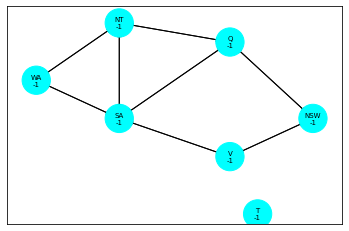

In [1]:
# csp
import random
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt

class Thing:
    def __init__(self, name=''):
        self.name = name
    def __repr__(self):
        return self.name

class Problem(Thing):
    def __init__(self, name):
        super().__init__(name)

class Node(Thing):
    def __init__(self, name, children=None, loc=None, state=-1):
        super().__init__(name)
        self.children = children if children is not None else {}
        self.loc = loc
        self.state = state
    def add_child(self, child_name, child_weight):
        self.children[child_name] = child_weight

class Graph(Thing):
    def __init__(self, name):
        super().__init__(name)
        self.node_list = []
        self.node_map = {}
    def add_node(self, node):
        self.node_list.append(node)  # 如果我们希望node实际有一个位置属性，这里可变
        self.node_map[node.name] = node
    def draw(self, font_size=10, k_layout=0.1):
        plt.rcdefaults()
        plt.rcParams['figure.dpi'] = 150
        g = nx.DiGraph()
        # g = nx.Graph()
        edges = []
        edges_map = {}
        for node in self.node_list:
            for key, val in node.children.items():
                edges.append((node.name, key, 1 / val))
                edges_map[(node.name, key)] = val
        # print(edges)
        g.add_weighted_edges_from(edges)
        # 有孤立点，因此需要额外处理一下边中没有涉及的点
        g.add_nodes_from(self.node_map)
        # {'':(x,y)}
        pos_map = {}
        nodes_label = {}
        for node in self.node_list:
            if node.loc is not None:
                pos_map[node.name] = node.loc
            nodes_label[node.name] = node.name + "\n" + str(node.state)
        # print(pos_map)
        rand_seed = random.randint(1, 1000)
        if len(pos_map) > 0:
            locs = nx.spring_layout(g, pos=pos_map, fixed=pos_map.keys(), seed=rand_seed, k=k_layout)
        else:
            locs = nx.spring_layout(g, seed=rand_seed, k=k_layout)
        # print(locs)
        color_arr = []
        for node_g in g.nodes:
            color_arr.append(self.node_map[node_g].state)
        # print(color_arr)
        nx.draw_networkx_nodes(g, pos=locs,
                               node_size=800,
                               node_color=color_arr,
                               cmap=plt.cm.cool)
        nx.draw_networkx_labels(g, pos=locs,
                                labels=nodes_label,
                                font_size=font_size,
                                font_color='black')
        # print(nodes_label)
        nx.draw_networkx_edges(g, pos=locs, )
        # print(locs)
        # nx.draw_networkx_edge_labels(g, pos=locs,
        #                              edge_labels=edges_map,
        #                              font_size=font_size - 1)
        # print(edges_map)

class AustraliaProblemGraph(Graph, Problem):
    def __init__(self, name):
        super().__init__(name)
        australia_nodes = pd.read_csv("../data/australia_nodes.csv")
        australia_edges = pd.read_csv("../data/australia_edges.csv")
        for idx, (s, e, w) in australia_edges.iterrows():
            self.add_edge((s, e, w))
        for idx, (s, x, y) in australia_nodes.iterrows():
            if not np.isnan(x) or not np.isnan(y):
                if s not in self.node_map:
                    node_s = Node(s)
                    self.add_node(node_s)
                self.node_map[s].loc = (x, y)
    def add_edge(self, edge):
        if edge[0] in self.node_map:
            node_0 = self.node_map[edge[0]]
        else:
            node_0 = Node(edge[0])
            self.add_node(node_0)
        if edge[1] in self.node_map:
            node_1 = self.node_map[edge[1]]
        else:
            node_1 = Node(edge[1])
            self.add_node(node_1)
        node_0.add_child(node_1.name, edge[2])
        node_1.add_child(node_0.name, edge[2])

problem = AustraliaProblemGraph('Color')
problem.draw(font_size=7, k_layout=0.3)

找到符合3色要求的解
{'T': 0, 'V': 0, 'NSW': 1, 'Q': 0, 'SA': 1, 'NT': 2, 'WA': 0}


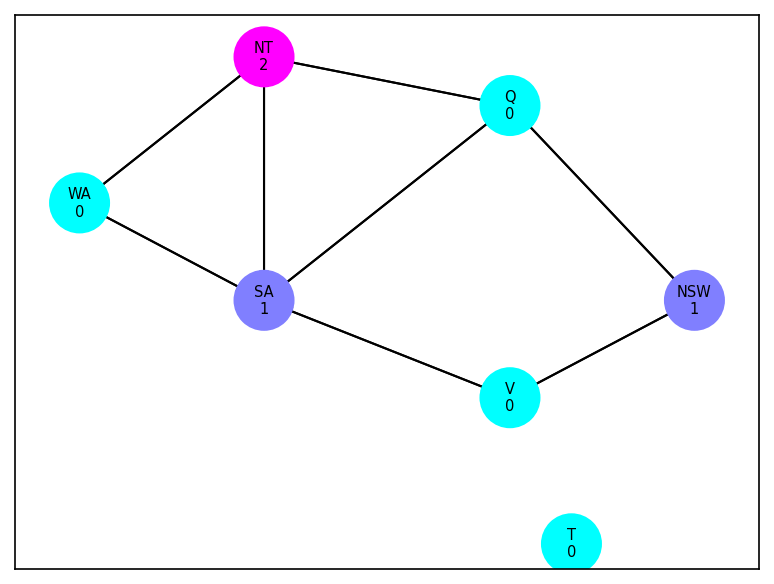

In [27]:
# 基本回溯
class BacktrackingAustralia(AustraliaProblemGraph):
    def __init__(self, name):
        super().__init__(name)
    # 颜色以1234来定，绘图时让图案自动区分
    def basic_backtracking_search(self, color_num=4):
        color_map = {}
        if self.recursive_backtracking_search(color_map=color_map,
                                              color_arr=[c for c in range(color_num)],
                                              uncolored_nodes=[node for node in self.node_list]):
            print("找到符合{}色要求的解".format(color_num))
            print(color_map)
            # 将节点的state赋值为color
            for node_name, node_color in color_map.items():
                self.node_map[node_name].state = node_color
            self.draw(font_size=7, k_layout=0.3)
        else:
            print("所选颜色不足以完成{}色问题".format(color_num))
    # 比较所有点
    def check_assignment_all(self, color_map):
        for node in self.node_list:
            for child_name in node.children:
                if node.name in color_map and child_name in color_map:
                    if color_map[node.name] == color_map[child_name]:
                        return False
        return True
    # 只比较assignment的点就行
    def check_assignment(self, color_map, node, color):
        if len(node.children)>0:
            for child_name in node.children:
                if child_name in color_map and color_map[child_name] == color:
                    return False
        return True
    def recursive_backtracking_search(self, color_map, color_arr, uncolored_nodes):
        if len(uncolored_nodes)>0:
            node = uncolored_nodes.pop()
            for color in color_arr:
                if self.check_assignment(color_map, node, color):
                    color_map[node.name] = color
                    return self.recursive_backtracking_search(color_map, color_arr, uncolored_nodes)
            return False
        else:
            return True

problem = BacktrackingAustralia('Backtracking')
problem.basic_backtracking_search(3)

In [6]:
# AC-3
class AC3Australia(AustraliaProblemGraph):
    def __init__(self, name):
        super().__init__(name)
    # 使用AC3对初始情况进行检查，减少冲突，再回溯求解
    def ac3_backtracking_search(self, color_num=4):
        # 一开始每个节点都有N种可能的颜色
        color_arr = [c for c in range(color_num)]
        color_map = {}
        for node in self.node_list:
            color_map[node.name] = color_arr.copy()
        # 构造起始情况，令节点1只有一个值
        color_map[self.node_list[0].name] = color_map[self.node_list[0].name][:1]
        print(color_map)
        # 遍历所有边，检查各个相关边的相容性
        queue = self.node_list.copy()
        result, color_map = self.ac3(queue,color_map)
        if result:
            print("找到了相容解")
            print(color_map)
            # 将节点的state赋值为color
            for node_name, node_color in color_map.items():
                self.node_map[node_name].state = node_color
            self.draw(font_size=7, k_layout=0.3)
        else:
            print("无法找到相容解")
    def ac3(self, queue, color_map):
        while len(queue)>0:
            node = queue.pop()
            # 检查node连接的所有节点，如果该节点的颜色和node的冲突，则删除，如果发生修改，则把新节点送入queue
            if len(color_map[node.name])==1 and len(node.children) >0:
                for child in node.children:
                    if color_map[node.name][0] in color_map[child]:
                        if len(color_map[child]) == 1:
                            # 如果修改后，child没有可用颜色了
                            return False, color_map
                        else:
                            color_map[child].remove(color_map[node.name][0])
                            # 发生了修改，把child再送入queue
                            queue.append(self.node_map[child])
        # 检查此时是否得到解
        if sum([len(color_map[cs]) for cs in color_map]) != len(color_map):
            # 如果还有某个节点有多种取值，将其值选一个，并送入递归
            for cs in color_map:
                if len(color_map[cs])>1:
                    for c in color_map[cs]:
                        color_map_c = color_map.copy()
                        color_map_c[cs] = [c]
                        queue.append(self.node_map[cs])
                        result, color_map =  self.ac3(queue, color_map_c)
                        if result: # 找到了可行解，否则尝试下一个颜色
                            return result, color_map
        else:
            return True, color_map

problem = AC3Australia('Backtracking')
problem.ac3_backtracking_search(2)

{'WA': [0], 'NT': [0, 1], 'SA': [0, 1], 'Q': [0, 1], 'NSW': [0, 1], 'V': [0, 1], 'T': [0, 1]}
无法找到相容解
